In [ ]:
import librosa
import numpy as np
import os
import librosa.display
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, Dense, Dropout, LSTM, Bidirectional, Reshape, Flatten

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=22050)  # Load audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCCs
    mfcc = np.mean(mfcc, axis=1)
    return mfcc

# Load Dataset
dataset_path = "/content/drive/MyDrive/Colab Notebooks/SDP/Augmentated data"

X, y = [], []
species_labels = {species: idx for idx, species in enumerate(os.listdir(dataset_path))}

for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)

    for file in os.listdir(species_path):
        file_path = os.path.join(species_path, file)
        mfcc_features = extract_mfcc(file_path)
        X.append(mfcc_features)
        y.append(species_labels[species])

X = np.array(X)
y = np.array(y)

print(f"Extracted MFCC features shape: {X.shape}")

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1975
  warnings.warn(


Extracted MFCC features shape: (1500, 40)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [ ]:
# Adjust based on MFCC structure
X_train = X_train.reshape((X_train.shape[0], 10, 4, 1))
X_test = X_test.reshape((X_test.shape[0], 10, 4, 1))


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

model3 = keras.Sequential([
    # 1. 2D Convolutional Layers (CNN) with Regularization
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(10, 4, 1),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # 2. Reshape for LSTM
    layers.Reshape((-1, 64 * (10 // 2))),


    # 3. BiLSTM Layers with Regularization
    layers.Bidirectional(layers.LSTM(256, activation='tanh', return_sequences=True,
                                     recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(128, activation='tanh', recurrent_dropout=0.3)),


    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduced LR
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Model Summary
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 10, 4, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 4, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 10, 4, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 10, 4, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 4, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 2, 320)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 2, 512)              │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,054,915 (7.84 MB)

 Trainable params: 2,054,723 (7.84 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = model3.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.5992 - loss: 1.3462 - val_accuracy: 0.8367 - val_loss: 0.8879
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7945 - loss: 0.8962 - val_accuracy: 0.9167 - val_loss: 0.6214
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8617 - loss: 0.6831 - val_accuracy: 0.9000 - val_loss: 0.5122
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9043 - loss: 0.5471 - val_accuracy: 0.8833 - val_loss: 0.5135
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8882 - loss: 0.4986 - val_accuracy: 0.9233 - val_loss: 0.4115
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9169 - loss: 0.4215 - val_accuracy: 0.9400 - val_loss: 0.3577
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9227 - loss: 0.3563 - val_accuracy: 0.9500 - val_loss: 0.2838
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9400 - loss: 0.3133 - val_acc

In [ ]:
loss, accuracy = model3.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9863 - loss: 0.1512
Test Accuracy: 97.67%


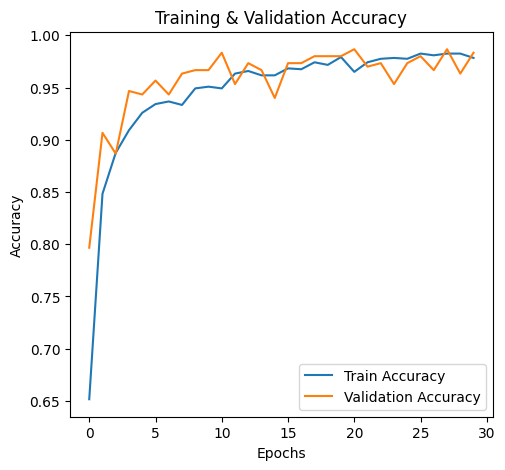

In [ ]:
import matplotlib.pyplot as plt


def plot_training_curves(history):

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')


plot_training_curves(history)


#Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       104
           1       0.95      1.00      0.97        86
           2       1.00      0.95      0.97       110

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



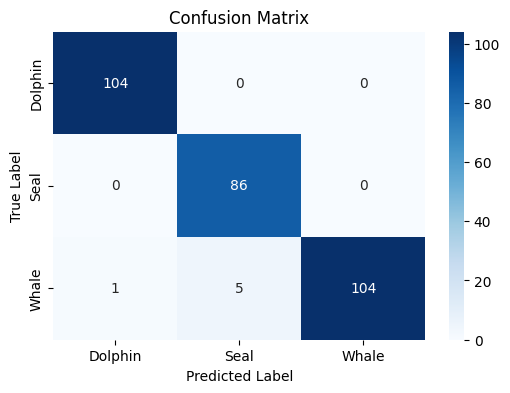

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(species_labels.keys()),
            yticklabels=list(species_labels.keys()))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

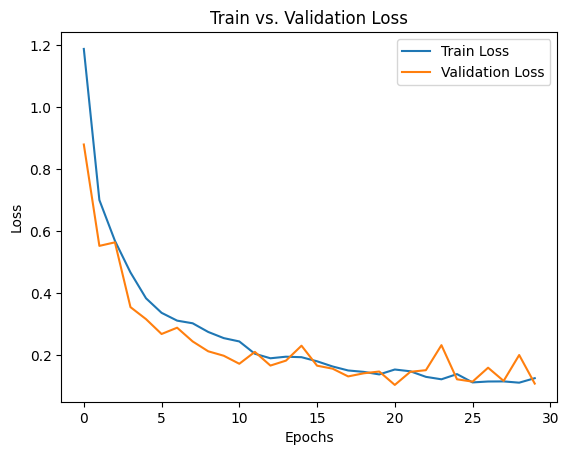

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs. Validation Loss')
plt.show()

In [ ]:
# Save the trained model
model3.save('/content/drive/MyDrive/Colab Notebooks/SDP/Trained Model/my_trained_model.h5')

In [ ]:
import numpy as np

# Extract loss values from history
epochs = np.arange(1, len(history.history['loss']) + 1)
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Print values as coordinate pairs (Epoch, Loss)
train_loss_coords = list(zip(epochs, train_loss))
val_loss_coords = list(zip(epochs, val_loss))

print("Training Loss Coordinates:")
print(train_loss_coords)

print("\nValidation Loss Coordinates:")
print(val_loss_coords)


Training Loss Coordinates:
[(np.int64(1), np.float64(1.1877244710922241)), (np.int64(2), np.float64(0.7006326913833618)), (np.int64(3), np.float64(0.5692324042320251)), (np.int64(4), np.float64(0.4671614468097687)), (np.int64(5), np.float64(0.383831650018692)), (np.int64(6), np.float64(0.33700254559516907)), (np.int64(7), np.float64(0.31179243326187134)), (np.int64(8), np.float64(0.3032466173171997)), (np.int64(9), np.float64(0.27531036734580994)), (np.int64(10), np.float64(0.2554270923137665)), (np.int64(11), np.float64(0.24470797181129456)), (np.int64(12), np.float64(0.20500017702579498)), (np.int64(13), np.float64(0.1904447376728058)), (np.int64(14), np.float64(0.19553665816783905)), (np.int64(15), np.float64(0.1939374953508377)), (np.int64(16), np.float64(0.1807076632976532)), (np.int64(17), np.float64(0.1640152782201767)), (np.int64(18), np.float64(0.15113644301891327)), (np.int64(19), np.float64(0.14666427671909332)), (np.int64(20), np.float64(0.13840283453464508)), (np.int64(21)

In [ ]:
# Function to Predict Species from an Uploaded Audio File
def predict_species(file_path):
    """Predicts the species of an audio file."""
    mfcc_features = extract_mfcc(file_path)

    # Reshape the input for CNN-LSTM
    mfcc_features = np.reshape(mfcc_features, (1, 10, 4, 1))  # Adjust based on model input shape

    prediction = model3.predict(mfcc_features)
    predicted_label = np.argmax(prediction)
    species_name = list(species_labels.keys())[list(species_labels.values()).index(predicted_label)]

    return species_name


# Upload an audio file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
file_path = '/content/' + filename

# Predict species
print("Predicted Species:", predict_species(file_path))

Saving 51041C01.wav to 51041C01.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Species: Dolphin


#count


#
feature comparsion to identify duplication makin sure same or different species but same name also count when if one after the other.

Case 1: one dolphin if lenght is 5 and segement are 2,2,1 should consider as 1 count only as they are from same dolphin sounds

case 2 :like dolphin after dolphin with making sure of case 1

In [ ]:
!pip install dtw

  Preparing metadata (setup.py) ... done
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5301 sha256=84ceca613492d169fbcac61df4e94e139370a88743e1cbe6c2fdb1ac75ccdb8d
  Stored in directory: /root/.cache/pip/wheels/2c/16/01/ffea89493a0fcd29934418eb0bf10161470acf8d5647bab656
Successfully built dtw


In [ ]:
import librosa
import numpy as np
import scipy.spatial
from dtw import accelerated_dtw
import tensorflow as tf

def extract_mfcc(y, sr, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def segment_audio(file_path, segment_length=2.0, overlap=1.0):
    y, sr = librosa.load(file_path, sr=22050)
    segment_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)
    segments, timestamps = [], []

    start = 0
    while start + segment_samples <= len(y):
        segment = y[start:start + segment_samples]
        mfcc = extract_mfcc(segment, sr)
        segments.append(mfcc)
        timestamps.append(start / sr)
        start += segment_samples - overlap_samples

    return np.array(segments), timestamps

def compute_similarity(feature1, feature2, method="cosine"):
    if method == "cosine":
        return 1 - scipy.spatial.distance.cosine(feature1, feature2)
    elif method == "dtw":
        distance, _, _, _ = accelerated_dtw(feature1.reshape(-1, 1), feature2.reshape(-1, 1), dist='euclidean')
        return -distance  # Lower DTW distance means higher similarity
    return 0

def count_species_occurrences(segments, timestamps, predictions, similarity_threshold=0.8, dtw_threshold=-5):
    counted_species = []
    species_count = {}
    last_species = None
    last_features = None
    last_time = -10

    for i, (species, features, time) in enumerate(zip(predictions, segments, timestamps)):
        if species not in species_count:
            species_count[species] = 0

        if last_species == species:
            cosine_sim = compute_similarity(features, last_features, method="cosine")
            dtw_sim = compute_similarity(features, last_features, method="dtw")

            # Case 1
            if cosine_sim >= similarity_threshold or dtw_sim >= dtw_threshold:
                continue

        # Case 2
        species_count[species] += 1
        counted_species.append(species)
        last_species = species
        last_features = features
        last_time = time

    return species_count, counted_species


model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/SDP/Trained Model/my_trained_model.h5')

def predict_species(audio_file):
    segments, timestamps = segment_audio(audio_file)
    reshaped_segments = segments.reshape(segments.shape[0], 10, 4, 1)
    predictions = model.predict(reshaped_segments)

    species_mapping = {0: "Dolphin", 1: "Seal", 2: "Whale"}
    species_predictions = [species_mapping[np.argmax(pred)] for pred in predictions]

    return count_species_occurrences(segments, timestamps, species_predictions)


audio_file_path = "/content/drive/MyDrive/Colab Notebooks/SDP/Merge audio/Merged audio/merged_audio.wav"
species_count, detection_sequence,total_species_Detected = predict_species(audio_file_path)
print("Species Count:", species_count)
print("Detection Sequence:", detection_sequence)
print("Detection Sequence:", total_species_Detected)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Species Count: {'Dolphin': 23, 'Whale': 32, 'Seal': 33}
Detection Sequence: ['Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Seal', 'Dolphin', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Seal', 'Dolphin', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Dolphin', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal']


# 88


In [ ]:
import keras
import librosa
import numpy as np
import scipy.spatial
from dtw import accelerated_dtw
import tensorflow as tf

# Function to extract MFCC features
def extract_mfcc(y, sr, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

# Function to segment audio into smaller clips with overlap
def segment_audio(file_path, segment_length=2.0, overlap=1.0):
    y, sr = librosa.load(file_path, sr=22050)
    segment_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)
    segments, timestamps = [], []

    start = 0
    while start + segment_samples <= len(y):
        segment = y[start:start + segment_samples]
        mfcc = extract_mfcc(segment, sr)
        segments.append(mfcc)
        timestamps.append(start / sr)
        start += segment_samples - overlap_samples

    return np.array(segments), timestamps

# Function to compute similarity between two features using cosine or DTW
def compute_similarity(feature1, feature2, method="cosine"):
    if method == "cosine":
        return 1 - scipy.spatial.distance.cosine(feature1, feature2)
    elif method == "dtw":
        distance, _, _, _ = accelerated_dtw(feature1.reshape(-1, 1), feature2.reshape(-1, 1), dist='euclidean')
        return -distance  # Lower DTW distance = higher similarity
    return 0

# Function to count species occurrences
def count_species_occurrences(segments, timestamps, predictions, similarity_threshold=0.8, dtw_threshold=-5, seal_gap_threshold=3):
    counted_species = []
    species_count = {}
    last_species = None
    last_features = None
    last_time = -10

    for i, (species, features, time) in enumerate(zip(predictions, segments, timestamps)):
        if species not in species_count:
            species_count[species] = 0

        if last_species == species:
            cosine_sim = compute_similarity(features, last_features, method="cosine")
            dtw_sim = compute_similarity(features, last_features, method="dtw")

            # Check if this occurrence is similar enough to the last one (case 1)
            if cosine_sim >= similarity_threshold or dtw_sim >= dtw_threshold:
                continue

        # Handle Seal detection to avoid overcounting (case 2)
        if species == "Seal" and (time - last_time < seal_gap_threshold):
            continue  # Skip if Seal appears too soon after the last occurrence

        # Count the occurrence
        species_count[species] += 1
        counted_species.append(species)
        last_species = species
        last_features = features
        last_time = time

    return species_count, counted_species

# Load the trained model
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/SDP/Trained Model/my_trained_model.h5')

# Function to predict species from an audio file
def predict_species(audio_file):
    segments, timestamps = segment_audio(audio_file)
    reshaped_segments = segments.reshape(segments.shape[0], 10, 4, 1)  # Reshape as needed for the model
    predictions = model.predict(reshaped_segments)

    # Mapping the predicted labels to species names
    species_mapping = {0: "Dolphin", 1: "Seal", 2: "Whale"}
    species_predictions = [species_mapping[np.argmax(pred)] for pred in predictions]

    species_count, detection_sequence = count_species_occurrences(segments, timestamps, species_predictions)

    total_species_detected = len(detection_sequence)  # Total detections after filtering

    return species_count, detection_sequence, total_species_detected

# Path to the audio file (update as needed)
audio_file_path = "/content/drive/MyDrive/Colab Notebooks/SDP/Merge audio/Merged audio/merged_audio.wav"

# Call the predict_species function to get the results
species_count, detection_sequence, total_species_detected = predict_species(audio_file_path)

# Print the results
print("Species Count:", species_count)
print("Detection Sequence:", detection_sequence)
print("Total Species Detected:", total_species_detected)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
Species Count: {'Dolphin': 22, 'Whale': 31, 'Seal': 29}
Detection Sequence: ['Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Seal', 'Dolphin', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Seal', 'Whale', 'Dolphin', 'Seal', 'Dolphin', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Seal', 'Whale', 'Dolphin', 'Whale', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Dolphin', 'Whale', 'Seal', 'Seal', 'Whale', 'Seal']
Total Species Detected: 82
